In [22]:
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
# import pydda
import wradlib as wrl
import xarray as xr
import xradar as xd
import datatree
import urllib.request
url = "https://raw.githubusercontent.com/syedhamidali/test_scripts/master/map_features.py"
urllib.request.urlretrieve(url, "map_features.py")
import map_features as mf
import pyart
# import pandas as pd
import datetime as dt
import numpy as np
import pathlib
import scipy
# import wradlib as wrl
# import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter, FuncFormatter
from matplotlib import axes
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import USCOUNTIES
import glob, os, sys, re
%matplotlib inline

In [23]:
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1/"
cow = os.path.join(basedir, "COW1/cmerged/20220322/")

In [24]:
files = glob.glob(os.path.join(cow, "*"))
files.sort()
len(files)

181

In [25]:
def most_common_value(ds: xr.Dataset, variable: str) -> xr.Dataset:
    """
    Replace the values of a variable in an xarray dataset with the most common value.

    Parameters:
        ds (xr.Dataset): The input dataset.
        variable (str): The name of the variable that will be replaced with the most common value.

    Returns:
        xr.Dataset: The output dataset with the specified variable replaced by a scalar value, 
        which is the most common value. The shape of the variable will be reduced to 1 and also the 
        attributes of the variable will be preserved.

    Example:
        ds = xr.open_dataset("path/to/dataset.nc")
        ds = most_common_value(ds, "variable_name")
    """
    # Select the specified variable
    var = ds[variable]
    # Calculate the most common value
    most_common = Counter(var.values.ravel()).most_common(1)[0][0]
    # Replace the values of the variable with the most common value
    ds[variable] = most_common.astype(np.float32)
    ds[variable].attrs = var.attrs
    return ds

In [55]:
ds = xr.open_dataset(files[111], engine="cfradial1")

In [54]:
for file in files[111:112]:
    ds = xr.open_dataset(file, engine="cfradial1")
    for coord in ["longitude", "latitude", "altitude", "altitude_agl"]:
        ds = most_common_value(ds, coord)
    root = xd.io.backends.cfradial1._get_required_root_dataset(ds)
    radar_parameters = xd.io.backends.cfradial1._get_subgroup(
    ds, xd.model.radar_parameters_subgroup)
    georeference_correction = xd.io.backends.cfradial1._get_subgroup(
    ds, xd.model.georeferencing_correction_subgroup)
    sweeps = xd.io.backends.cfradial1._get_sweep_groups(ds)

ValueError: cannot rename 'sweep_number' because it is not a variable or coordinate in this dataset

In [49]:
vol = root.map_over_subtree(extract_clutter, 
                           "DBZHCC_F", 
                           "CMAP", 
                           wsize=3, 
                           thrsnorain=0.0, 
                           tr1=14, n_p=2, tr2=1.5, 
                           rm_nans=False)

AttributeError: 'Dataset' object has no attribute 'map_over_subtree'

In [31]:
swp0 = sweeps['sweep_0'].pipe(wrl.georef.georeference_dataset)

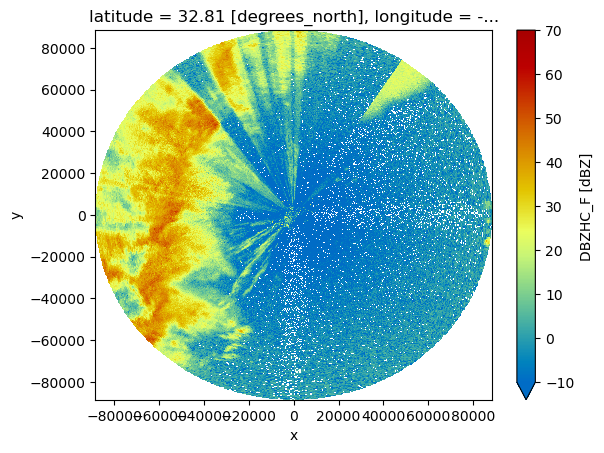

In [32]:
swp0.DBZHCC_F.plot(x="x", y="y", cmap="pyart_HomeyerRainbow", vmin = -10, vmax = 70)

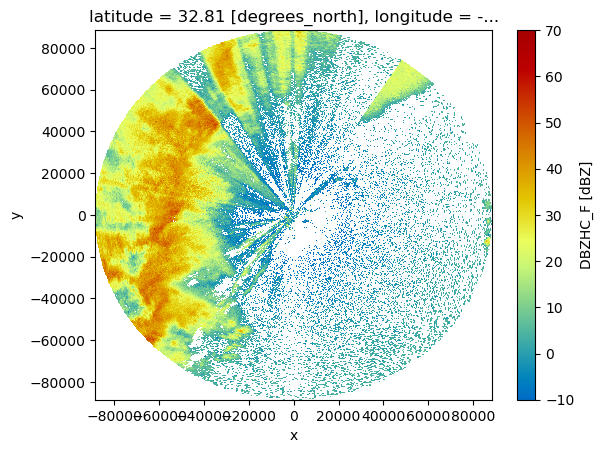

In [14]:
swp0.where((swp0.SNRHC>0) & ((swp0.DBZHCC_F<70) & (swp0.DBZHCC_F>-10)) &
           ((swp0.ZDRC <8) & (swp0.ZDRC>-8)) &
           (swp0.TRIP_FLA<3) & (swp0.PHIDP>-179.9)
          ).DBZHCC_F.plot(x="x", y="y", cmap="pyart_HomeyerRainbow", vmin = -10, vmax = 70)

In [15]:
def extract_clutter(da, wsize=3, thrsnorain=0, tr1=6.0, n_p=6, tr2=1.3, rm_nans=False):
    return xr.apply_ufunc(
        wrl.clutter.filter_gabella,
        da,
        input_core_dims=[["azimuth", "range"]],
        output_core_dims=[["azimuth", "range"]],
        dask="parallelized",
        kwargs=dict(
            wsize=wsize,
            thrsnorain=thrsnorain,
            tr1=tr1,
            n_p=n_p,
            tr2=tr2,
            rm_nans=rm_nans,
        ),
    )

In [16]:
clmap = swp0.DBZHC.pipe(
    extract_clutter, wsize=5, thrsnorain=0.0, tr1=21.0, n_p=23, tr2=1.3, rm_nans=False
)
swp = swp0.assign({"CMAP": clmap})
display(swp)

<xarray.Dataset>
Dimensions:                    (azimuth: 720, range: 1180)
Coordinates: (12/13)
    time                       (azimuth) datetime64[ns] 2022-03-22T20:45:19.5...
  * range                      (range) float32 87.5 162.4 ... 8.844e+04
  * azimuth                    (azimuth) float32 0.3 0.8 1.3 ... 359.3 359.8
    elevation                  (azimuth) float32 0.4876 0.4876 ... 0.4876 0.4876
    latitude                   float32 32.81
    longitude                  float32 -87.95
    ...                         ...
    x                          (azimuth, range) float32 0.4581 0.8505 ... -308.7
    y                          (azimuth, range) float32 87.5 162.4 ... 8.843e+04
    z                          (azimuth, range) float32 59.0 60.0 ... 1.271e+03
    gr                         (azimuth, range) float32 87.5 162.4 ... 8.843e+04
    rays                       (azimuth, range) float32 0.4876 0.4876 ... 0.4876
    bins                       (azimuth, range) float32 87.5 162.4 ... 8.844e+04
Data variables: (12/47)
    sweep_number               float64 ...
    sweep_mode                 |S32 b'azimuth_surveillance'
    prt_mode                   |S32 ...
    follow_mode                |S32 ...
    sweep_fixed_angle          float32 ...
    ray_start_range            (azimuth) float32 ...
    ...                         ...
    PHIDP                      (azimuth, range) float32 102.8 -115.5 ... -56.3
    KDP                        (azimuth, range) float32 ...
    DBZHCC                     (azimuth, range) float32 ...
    DBZHCC_F                   (azimuth, range) float32 -21.9 -1.39 ... 18.43
    ZDRC                       (azimuth, range) float32 3.43 1.12 ... -0.65 0.19
    CMAP                       (azimuth, range) bool False False ... False False

Text(0.5, 1.0, 'Reflectivity clutter removed')

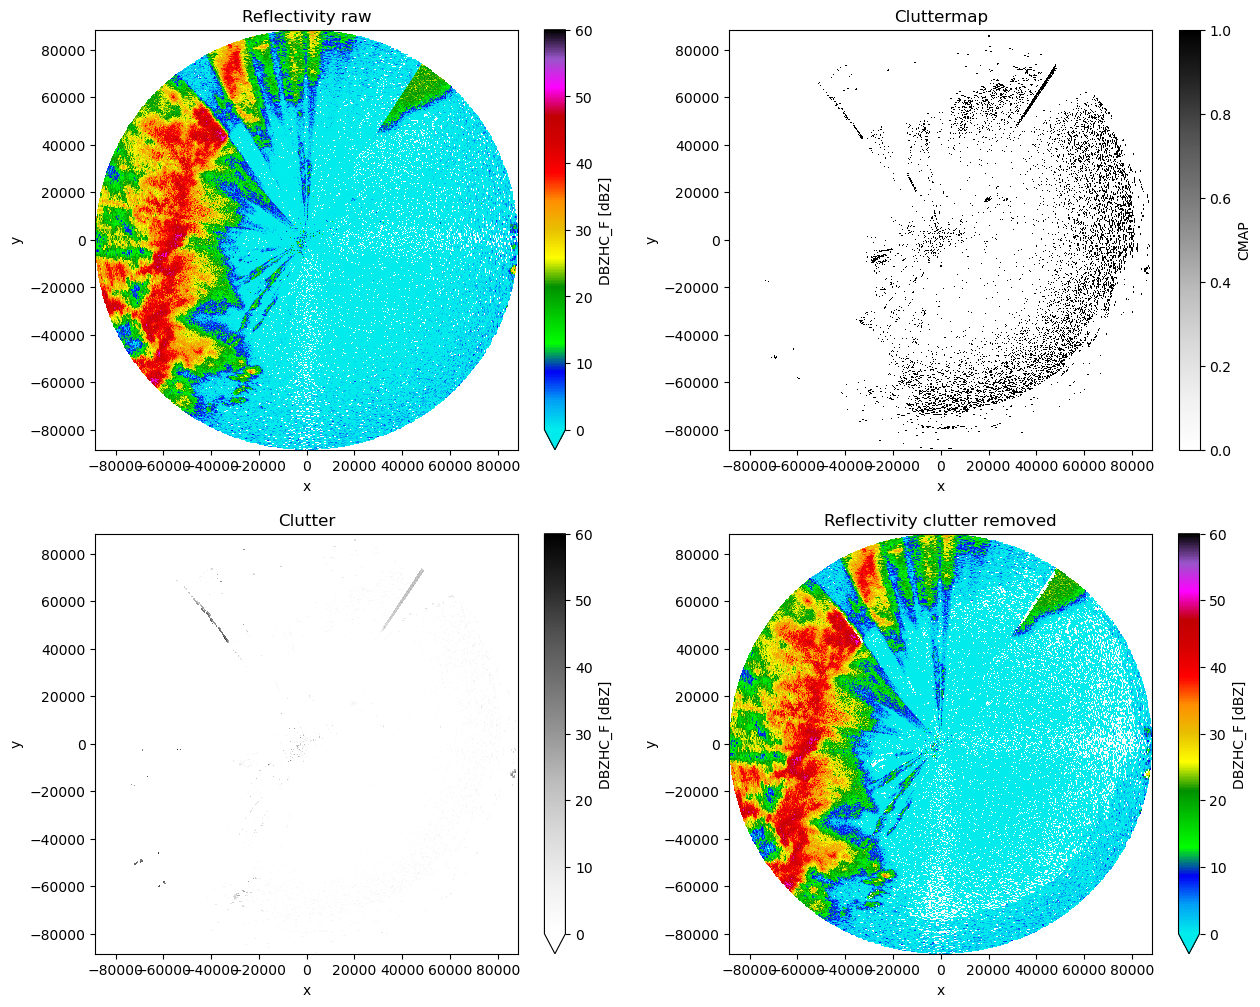

In [17]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(221)
swp.DBZHCC_F.plot(x="x", y="y", ax=ax1, vmin=0, vmax=60, cmap="pyart_NWSRef")
ax1.set_title("Reflectivity raw")
ax2 = fig.add_subplot(222)
swp.CMAP.plot(x="x", y="y", ax=ax2, cmap="Greys")
ax2.set_title("Cluttermap")
ax3 = fig.add_subplot(223)
swp.DBZHCC_F.where(swp.CMAP == 1).plot(
    x="x", y="y", ax=ax3, vmin=0, vmax=60, cmap="Greys")
ax3.set_title("Clutter")
ax4 = fig.add_subplot(224)
swp.DBZHCC_F.where(swp.CMAP < 1).plot(
    x="x", y="y", ax=ax4, vmin=0, vmax=60, cmap="pyart_NWSRef")
ax4.set_title("Reflectivity clutter removed")

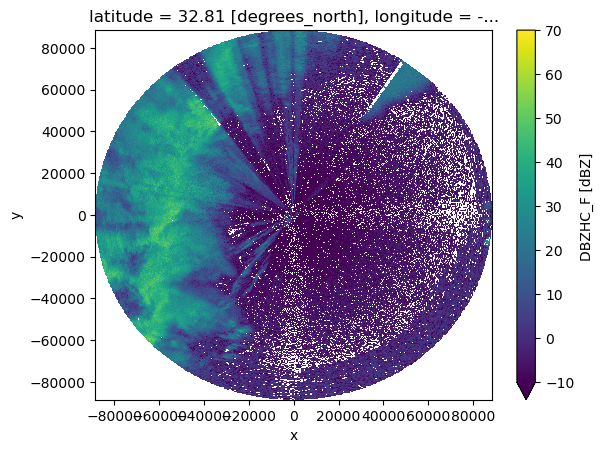

In [41]:
swp.DBZHCC_F.where(swp.CMAP < 1).plot(x = 'x', y = 'y', vmin=-10, vmax = 70)

In [21]:
swp.x.values.mean()

-2.2693703

## Inspect Scan Strategy

In [23]:
nrays = swp0.azimuth.size, 
nbins = swp0.range.size
range_res = swp0.range.diff(dim='range').mean().values
ranges = np.arange(nbins) * range_res
elevs = root.sweep_fixed_angle.values
sitecoords = (
    swp0.longitude.values.item(),
    swp0.latitude.values.item(),
    swp0.altitude.values.item(),
)

bw = beamwidth = 1.1
r = swp0.range.values
az = swp0.azimuth.values
beamradius = wrl.util.half_power_radius(r, bw)

In [24]:
az.shape

(720,)

In [25]:
az.min(), az.max()

(0.3, 359.8)

In [26]:
sitecoords

(-87.94601440429688, 32.810977935791016, 58.0)

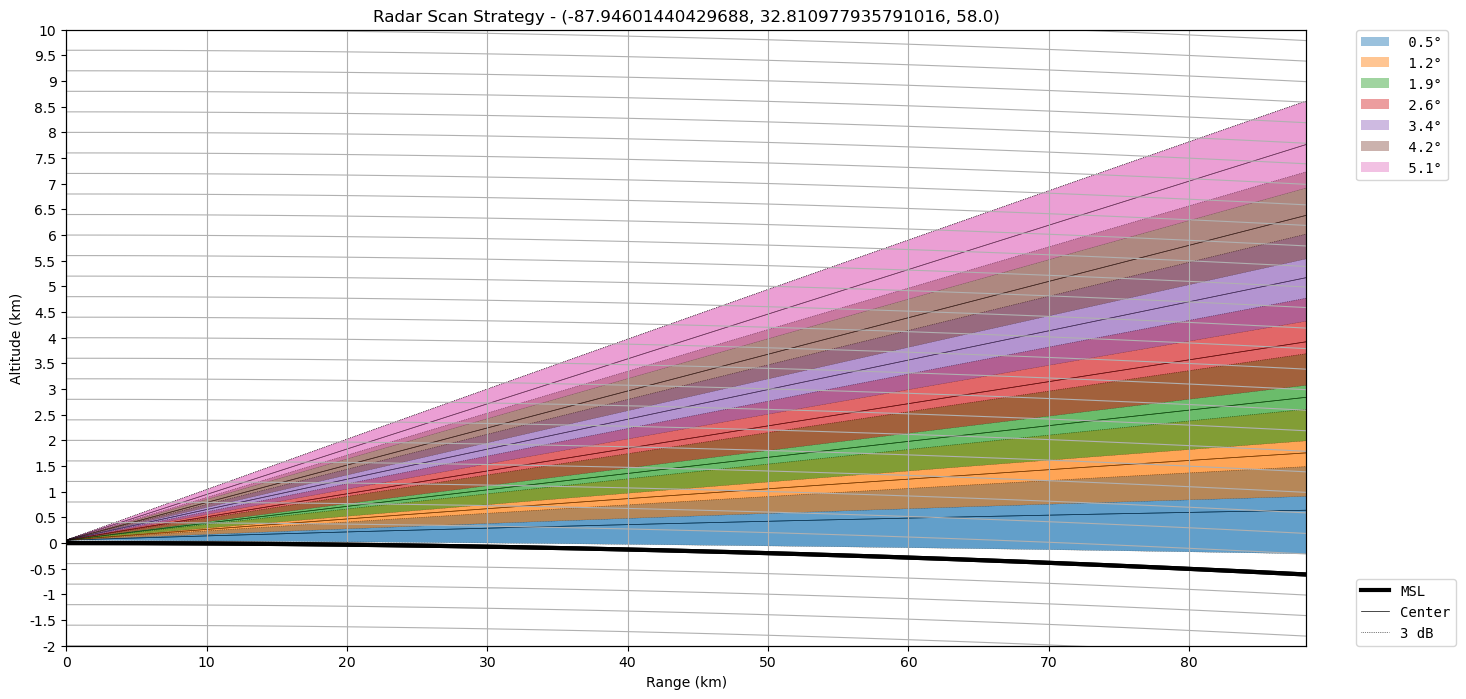

In [27]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords, beamwidth, units="km", cg=True)

In [16]:
lons,lats = pyart.core.cartesian_to_geographic_aeqd(swp0.x.values, swp0.y.values, 
                                        lon_0 = swp0.longitude.values,
                                        lat_0=swp0.latitude.values)

In [17]:
extnt = lons.min(), lons.max(), lats.min(), lats.max()

In [18]:
dirs = ['left', 'right', 'bottom', 'top']

In [19]:
extent = {}
for i, direction in enumerate(dirs):
    extent[direction] = extnt[i]

In [20]:
extent

{'left': -88.89223, 'right': -86.99979, 'bottom': 32.015724, 'top': 33.606228}

In [32]:
extent = wrl.zonalstats.get_bbox(swp0.x.values, swp0.y.values)
extent

{'left': -88428.69, 'right': 88428.37, 'bottom': -88428.055, 'top': 88428.055}

In [ ]:
os.environ["WRADLIB_DATA"] = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/

In [ ]:
# apply fake token, data is already available
# os.environ["WRADLIB_EARTHDATA_BEARER_TOKEN"] = ""
# set location of wradlib-data, where wradlib will search for any available data
# os.environ["WRADLIB_DATA"] = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/"
# get the tiles
demds = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/seus.tif"
dem = wrl.io.open_raster(demds)
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(
    dem, nodata=-32768.0
)

rlimits = (extent["left"], extent["bottom"], extent["right"], extent["top"])
# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

polcoords = np.dstack([swpx.x.values, swpx.y.values])
# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(
    rastercoords, rastervalues, polcoords, order=3, prefilter=False
)

In [ ]:
demds = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/seus.tif"
os.environ["WRADLIB_DATA"] = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/"

In [ ]:
# rasterfile = wrl.util.get_wradlib_data_file('geo/bonn_gtopo.tif')
rasterfile = wrl.util.get_wradlib_data_file(demds)

ds = wrl.io.open_raster(rasterfile)
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(
    ds, nodata=-32768.0
)

# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(
    rastercoords, rastervalues, polcoords, order=3, prefilter=False
)

In [ ]:
swp0.TRIP_FLA.plot()

In [ ]:
def phase_offset(phioff, method=None, rng=3000.0, npix=None, **kwargs):
    """Calculate Phase offset.

    Parameter
    ---------
    phioff : xarray.DataArray
        differential phase DataArray

    Keyword Arguments
    -----------------
    method : str
        aggregation method, defaults to 'median'
    rng : float
        range in m to calculate system phase offset

    Return
    ------
    phidp_offset : xarray.Dataset
        Dataset with PhiDP offset and start/stop ranges
    """
    range_step = np.diff(phioff.range)[0]
    nprec = int(rng / range_step)
    if nprec % 2:
        nprec += 1

    if npix is None:
        npix = nprec // 2 + 1

    # create binary array
    phib = xr.where(np.isnan(phioff), 0, 1)

    # take nprec range bins and calculate sum
    phib_sum = phib.rolling(range=nprec, **kwargs).sum(skipna=True)

    # find at least N pixels in
    # phib_sum_N = phib_sum.where(phib_sum >= npix)
    phib_sum_N = xr.where(phib_sum <= npix, phib_sum, npix)

    # get start range of first N consecutive precip bins
    start_range = (
        phib_sum_N.idxmax(dim="range") - nprec // 2 * np.diff(phib_sum.range)[0]
    )
    start_range = xr.where(start_range < 0, 0, start_range)

    # get stop range
    stop_range = start_range + rng
    # get phase values in specified range
    off = phioff.where(
        (phioff.range >= start_range) & (phioff.range <= stop_range), drop=False
    )
    # calculate nan median over range
    if method is None:
        method = "median"
    func = getattr(off, method)
    off_func = func(dim="range", skipna=True)

    return xr.Dataset(
        dict(
            PHIDP_OFFSET=off_func,
            start_range=start_range,
            stop_range=stop_range,
            phib_sum=phib_sum,
            phib=phib,
        )
    )

In [ ]:
phase_offset(phioff=swp.PHIDP, rng=swp.range[-1], )

In [ ]:
dr_m = swp.range.diff("range").median()
swp_msk = swp0.where((swp.DBZHCC_F >= 0.0))
swp_msk = swp_msk.where(swp_msk.RHOHV > 0.8)
swp_msk = swp_msk.where(swp_msk.range > dr_m * 5)

phi_masked = swp_msk.PHIDP.copy()
off = phase_offset(
    phi_masked, method="median", rng=2000.0, npix=7, center=True, min_periods=4
)
phioff = off.PHIDP_OFFSET.median(dim="azimuth", skipna=True)

In [ ]:
fig = plt.figure(figsize=(16, 7))
ax1 = plt.subplot(111, projection="polar")
# set the lable go clockwise and start from the top
ax1.set_theta_zero_location("N")
# clockwise
ax1.set_theta_direction(-1)
theta = np.linspace(0, 2 * np.pi, num=720, endpoint=False)
ax1.plot(theta, off.PHIDP_OFFSET, color="b", linewidth=3)
ax1.plot(theta, np.ones_like(theta) * phioff.values, color="r", lw=2)
ti = off.time.values.astype("M8[s]")
om = phioff.values
tx = ax1.set_title(f"{ti}\n" + r"$\phi_{DP}-Offset$ " + f"{om:.1f} (deg)")
tx.set_y(1.1)
xticks = ax1.set_xticks(np.pi / 180.0 * np.linspace(0, 720, 36, endpoint=False))
ax1.set_ylim(50, 150)

In [ ]:
fig = plt.figure(figsize=(18, 5))
swp_msk.DBZHCC_F.plot(x="azimuth")
off.start_range.plot(c="b", lw=2)
off.stop_range.plot(c="r", lw=2)
plt.gca().set_ylim(0, 25000)

In [ ]:
fig = plt.figure(figsize=(13, 5))

ax1 = fig.add_subplot(121)
im1 = swp.PHIDP.where(swp.RHOHV > 0.8).plot(x="x", y="y", ax=ax1, cmap="turbo")
t = plt.title(r"Uncorrected $\phi_{DP}$")
t.set_y(1.1)
ax2 = fig.add_subplot(122)
im2 = swp.DBZHCC_F.where(swp.RHOHV > 0.8).plot(
    x="x", y="y", ax=ax2, cmap="turbo", vmin=-10, vmax=50
)
t = plt.title(r"Uncorrected $Z_{H}$")
t.set_y(1.1)
fig.suptitle(swp.time.values, fontsize=14)
fig.subplots_adjust(wspace=0.25)
plt.show()